In [0]:
import numpy as np
import nibabel as nib
from math import ceil
from matplotlib import pyplot as plt
from skimage.measure import shannon_entropy
from copulas.bivariate import select_copula, Gumbel, Frank, Clayton
from scipy.stats import invgamma, chi2, t
from scipy.linalg import cholesky
from scipy.stats import kendalltau
from copulas.multivariate import GaussianMultivariate
import warnings
import time
import numba
import pandas as pd
import mvt
warnings.simplefilter('ignore')
from tqdm import tqdm
import gc
gc.enable()
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [0]:
# Data loading
t1_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a.nii')
t1_data = t1_img.get_data()
t2_img = nib.load('mni_icbm152_t2_tal_nlin_asym_09a.nii')
t2_data = t2_img.get_data()
# Slice of the Nifti image
t1_slice = t1_data[:, :, 94]
t2_slice = t2_data[:, :, 94]

In [0]:
# Plot parameters
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [0]:
# Flat the vector
t1 = t1_slice.flatten().astype(np.float16)
t2 = t2_slice.flatten().astype(np.float16)

In [0]:
n, m = t1_slice.shape

# Empiric copula
The calculation of this is necessary for the adjustment of an anlytic copula.
$C_n(\frac{i}{n}, \frac{j}{m}) = \frac{\# x \leq x_{(i)} \& y \leq y_{(i)}}{n}$

In [0]:
def em_copula(x,y):
    n = len(x)
    _xy = np.vstack((x,y)).T.reshape(n,2,1,1)
    _xy_sorted = np.stack((
        np.sort(x) + np.zeros((n,n)),
        (np.sort(y) + np.zeros((n,n))).T
    )).reshape(1,2,n,n)
    return np.all(_xy <= _xy_sorted, axis = 1).sum(axis = 0).T

This runs out of memory for our test images (and probably for all of the images we try)

In [0]:
#em_copula(t1,t2)

Next one is a better option in terms of memory, however, due to its iterative nature, is more time consuming.

In [0]:
def empirical(X,Y):
    n = len(X)
    XY = np.vstack((X,Y)).T
    sort_x = np.sort(X)
    sort_y = np.sort(Y)
    e_copula = np.zeros((n,n))
    for i in tqdm(range(n)):
        for j in range(n):
            c = np.sum(np.where( (np.sum(np.where((XY <= [sort_x[i],sort_y[j]]), 1, 0), axis = 1)) == 2, 1, 0))
            e_copula[i,j] = c/n
    return e_copula    

## Smoothing
This process will reduce the size of the image by a factor of $\varepsilon$, making the data more manageable

In [0]:
e = 0.5
# New size of the array
alpha = ceil(n*e)
beta = ceil(m*e)
# New image
n_t1 = np.zeros((alpha,beta))
# Size of the window
ne = ceil(n/alpha)
me = ceil(m/beta)

In [0]:
# Resizing
for i in range(alpha-1):
    for j in range(beta-1):
        n_t1[i,j] = np.mean(t1_slice[i*ne:(i+1)*ne, j*me: (j+1)*me])

### Original image
This is how the original image looks like

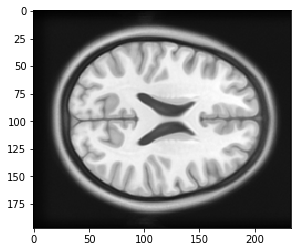

In [12]:
plt.imshow(t1_slice)
plt.show()

### Smoothed image
This is the image after a reduction of half 

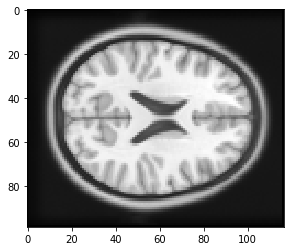

In [13]:
plt.imshow(n_t1)
plt.show()

They look very similar, don't they? But, how well does this final image represent the data? Let's find out by using the entropy measure

In [0]:
def smoothing(image, epsilon):
    n, m = image.shape
    # New size of the array
    alpha = ceil(n*epsilon)
    beta = ceil(m*epsilon)
    # New image
    n_image = np.zeros((alpha,beta))
    # Size of the window
    ne = ceil(n/alpha)
    me = ceil(m/beta)
    # Resizing
    for i in range(alpha-1):
        for j in range(beta-1):
            n_image[i,j] = np.mean(image[i*ne:(i+1)*ne, j*me: (j+1)*me])
    return n_image

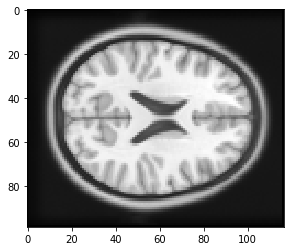

In [15]:
plt.imshow(smoothing(t1_slice, 0.5))
plt.show()

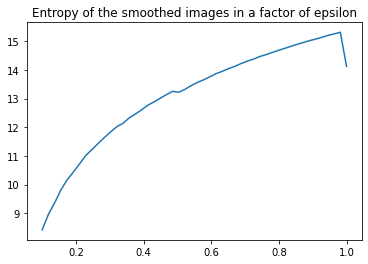

In [16]:
plt.plot(np.linspace(0.1,1,50),[shannon_entropy(smoothing(t1_slice, i)) for i in np.linspace(0.1,1,50)])
plt.title('Entropy of the smoothed images in a factor of epsilon')
plt.show()

### Redefinition of the images
Using the smoothing, we will select a smaller sample

In [0]:
n_t1 = smoothing(t1_slice, 0.2).flatten()
n_t1 = n_t1/max(n_t1)
n_t2 = smoothing(t2_slice, 0.2).flatten()
n_t2 = n_t2/max(n_t2)
n = len(n_t1) # number of samples to draw

In [18]:
n

20

## Copula fitting
First, let's take a look into the empiric copula for our dataset (smoothed).

In [19]:
empiric_copula = empirical(n_t1,n_t2)

100%|██████████| 20/20 [00:00<00:00, 1415.73it/s]


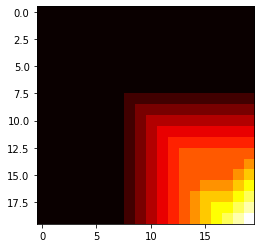

In [20]:
plt.imshow(empiric_copula, cmap='hot', interpolation='nearest')
plt.show()

Some built-in methods in Python use the empiric copula to compare against some known copulas and select the best fit using the kendall tau

In [21]:
copula = select_copula(np.vstack((n_t1,n_t2)).T)
copula.fit(np.vstack((n_t1,n_t2)).T)
n = len(n_t1)
copula.to_dict()

{'copula_type': 'CLAYTON',
 'tau': 0.8765432098765432,
 'theta': 14.200000000000001}

In [22]:
gumbel_copula = Gumbel()
gumbel_copula.fit(np.vstack((n_t1,n_t2)).T)
gumbel_copula.to_dict()

{'copula_type': 'GUMBEL', 'tau': 0.8765432098765432, 'theta': 8.1}

In [23]:
gumbel_sample = gumbel_copula.sample(n)
gumbel = empirical(gumbel_sample[:,0],gumbel_sample[:,1])

100%|██████████| 20/20 [00:00<00:00, 2460.07it/s]


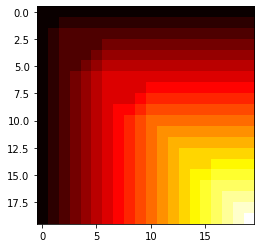

In [24]:
plt.imshow(gumbel,cmap='hot', interpolation='nearest')
plt.show()

## T-student copula
Can be simulated as a extreme value copula

In [0]:
# Define a correlation matrix, the p is a parameter
cm = np.array([[1,0.8],[0.8,1]])
# Find the cholesky matrix
L = cholesky(cm)
# Zero mean
mu = np.zeros(len(cm))
# Multivariate normal
Y = np.random.multivariate_normal(mu, cm, n)
Zd = np.exp(Y)
# Degrees of freedom of the t-student copula
df = 10
# Simulate a chi squared
S = np.random.chisquare(df)
Z = np.sqrt(df/S)*L@Y.T
# Simulated copula
U = np.vstack((mvt.multivariate_t.pdf(x=Z[0],mean = 0, df=df), mvt.multivariate_t.pdf(x=Z[1],mean = 0, df=df)))

In [26]:
copula_lognormal = empirical(Zd[:,0],Zd[:,1])
copula_t = empirical(U[0],U[1])

100%|██████████| 20/20 [00:00<00:00, 2090.93it/s]


In [0]:
def t_student_copula(rho,df):
  cm = np.array([[1,rho],[rho,1]])
  L = cholesky(cm)
  mu = np.zeros(len(cm))
  Y = np.random.multivariate_normal(mu, cm, n)
  Zd = np.exp(Y)
  S = np.random.chisquare(df)
  Z = np.sqrt(df/S)*L@Y.T
  # Simulated copula
  U1 = mvt.multivariate_t.pdf(x=Z[0],mean = 0, df=df)
  U2 = mvt.multivariate_t.pdf(x=Z[1],mean = 0, df=df)
  U = np.vstack((U1, U2))
  return num_empirical(U[0],U[1], n)

In [0]:
def objective(trial):
    df = trial.suggest_int('df', 1, 50)
    rho = trial.suggest_uniform('rho', 0.0, 1.0)
    t_copula = t_student_copula(rho,df)
    return kendalltau(empiric_copula, t_copula)[0]

In [32]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)
study.best_params

[I 2020-05-25 23:36:10,452] Finished trial#0 with value: 0.7727004611999118 with parameters: {'df': 31, 'rho': 0.9174852930762573}. Best is trial#0 with value: 0.7727004611999118.
[I 2020-05-25 23:36:10,564] Finished trial#1 with value: 0.7515888394634959 with parameters: {'df': 32, 'rho': 0.3932707745229823}. Best is trial#1 with value: 0.7515888394634959.
[I 2020-05-25 23:36:10,675] Finished trial#2 with value: 0.7497347492352489 with parameters: {'df': 29, 'rho': 0.34208024095027834}. Best is trial#2 with value: 0.7497347492352489.
[I 2020-05-25 23:36:10,788] Finished trial#3 with value: 0.7172466185217048 with parameters: {'df': 9, 'rho': 0.6640271641873368}. Best is trial#3 with value: 0.7172466185217048.
[I 2020-05-25 23:36:10,905] Finished trial#4 with value: 0.7353678076157172 with parameters: {'df': 38, 'rho': 0.08538582819736051}. Best is trial#3 with value: 0.7172466185217048.
[I 2020-05-25 23:36:11,021] Finished trial#5 with value: 0.7461830090378354 with parameters: {'df':

{'df': 9, 'rho': 0.6640271641873368}

### Copulas comparison
Bellow are shown 2 different extreme value copulas that can be adjusted ton our model, including the empiric copula, the t copula and the lognormal copula.

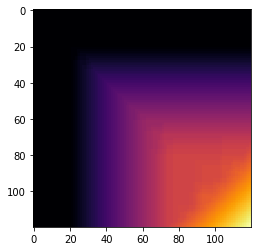

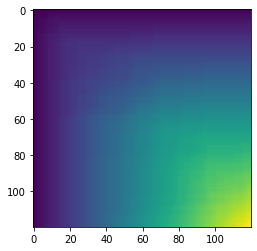

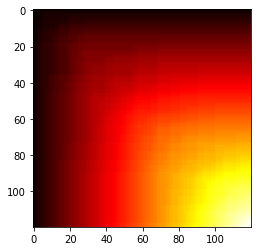

In [0]:
plt.imshow(empiric_copula,cmap='inferno', interpolation='nearest')
plt.show()
plt.imshow(copula_t,cmap='viridis', interpolation='nearest')
plt.show()
plt.imshow(copula_lognormal,cmap='hot', interpolation='nearest')
plt.show()

In [0]:
copula = GaussianMultivariate()
copula.fit(np.vstack((n_t1,n_t2)).T)

In [0]:
num_samples = n
samples = copula.sample(num_samples)

### Gaussian Copula
This is a commonly used copula, that is going to be compared in tau correlation with the other copulas in the process

In [0]:
gaussian_copula = empirical(samples[0],samples[1])

100%|██████████| 120/120 [00:00<00:00, 229.15it/s]


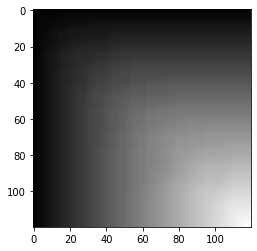

In [0]:
plt.imshow(gaussian_copula)
plt.show()

## Copula adjustment
Class copulas contains a fit method that allow the user to introduce the data and find out which copula adjust better to it and also the density function asociated with said copula. An example, named test, is shown bellow.

In [0]:
@numba.njit(parallel=True)
def num_empirical(X, Y, n):
        XY = np.vstack((X,Y)).T
        X.sort()
        Y.sort()
        e_copula = np.zeros((n, n))
        for i in numba.prange(n):
            for j in numba.prange(n):
                c = np.sum(np.where( (np.sum(np.where((XY <= np.array([X[i], Y[j]])), 1, 0), axis = 1)) == 2, 1, 0))
                e_copula[i,j] = c / n
        return e_copula

In [0]:
class Copulas:
    from copulas.bivariate import select_copula, Gumbel, Frank, Clayton
    from copulas.multivariate import GaussianMultivariate
    from scipy.stats import invgamma, chi2, t
    from scipy.linalg import cholesky
    from scipy.stats import kendalltau
    import numpy as np

    def __init__(self,data,n):
        self.data = data
        self.n = n
        self.empiric_copula = self.empirical(data[0],data[1])
        self.copula = None
        self.pdf = None
     
    def fit_copulas(self):
        g_copula = GaussianMultivariate()
        try:
          g_copula.fit(self.data.T)
          samples = g_copula.sample(self.n)
          self.gaussian_copula = {'tau': kendalltau(self.empirical(samples[0].values,samples[1].values), self.empiric_copula)[0]}
        except:
          self.gaussian_copula = {'tau': 0}
        gu_copula = Gumbel()
        try:        
          gu_copula.fit(self.data.T)
          samples = gu_copula.sample(self.n)
          self.gumbel_copula = {'tau': kendalltau(self.empirical(samples[:,0],samples[:,1]), self.empiric_copula)[0]}
        except:
          self.gumbel_copula = {'tau': 0}
        cl_copula = Clayton()
        try:
          cl_copula.fit(self.data.T)
          samples = cl_copula.sample(self.n)
          self.clayton_copula = {'tau': kendalltau(self.empirical(samples[:,0],samples[:,1]), self.empiric_copula)[0]}
        except:
          self.clayton_copula = {'tau' : 0}
        fr_copula = Frank()
        try:
          fr_copula.fit(self.data.T)
          samples = fr_copula.sample(self.n)
          self.frank_copula = {'tau': kendalltau(self.empirical(samples[:,0],samples[:,1]), self.empiric_copula)[0]}
        except:
          self.frank_copula = {'tau': 0}
        self.fit_t()
        print('Finished fitting t copula')
        self.fit_lognormal()
        print('Finished fitting lognormal copula')
        
    def fit(self):
        self.fit_copulas()
        rhos = [self.gaussian_copula['tau'], 
                self.gumbel_copula['tau'], 
                self.clayton_copula['tau'], 
                self.frank_copula['tau'], 
                self.lognormal['tau'], 
                self.t_copula['tau']]
        ind = np.argmax(rhos)
        if ind == 0:
            self.gaussian_final()
        elif ind == 1:
            self.gumbel_final()
        elif ind == 2:
            self.clayton_final()
        elif ind == 3:
            self.frank_final()
        elif ind == 4:
            self.lognormal_final()
        elif ind == 5:
            self.t_final()
        
    def gaussian_final(self):
        g_copula = GaussianMultivariate()
        g_copula.fit(self.data.T)
        samples = g_copula.sample(self.n)
        self.copula = {'copula_type': 'gaussian', 'copula': self.empirical(samples[0],samples[1])}
        self.pdf = g_copula.pdf

    def gumbel_final(self):
        gu_copula = Gumbel()
        gu_copula.fit(self.data.T)
        samples = gu_copula.sample(self.n)
        self.copula = {'copula_type': 'gumbel', 'copula': self.empirical(samples[:,0],samples[:,1])}
        self.pdf = gu_copula.pdf

    def clayton_final(self):
        cl_copula = Clayton()
        cl_copula.fit(self.data.T)
        samples = cl_copula.sample(self.n)
        self.copula = {'copula_type': 'clayton', 'copula': self.empirical(samples[:,0],samples[:,1])}
        self.pdf = cl_copula.pdf

    def t_final(self):
        rho = self.t_copula['rho']
        df = self.t_copula['df']
        cop = self.t_student_copula(rho,df,self.n)
        self.copula = {'copula_type': 't', 'copula': cop}
        self.pdf = self.t_density
        
    def lognormal_final(self):
        rho = self.lognormal['rho']
        cop = self.lognormal_copula(rho,self.n)
        self.copula = {'copula_type': 'lognormal', 'copula': cop}
        g_copula = GaussianMultivariate()
        g_copula.fit(self.data.T)
        self.pdf = lognormal_density
        
    def lognormal_density(self, X):
        return self.gaussian_copula.pdf(X)
        
    def frank_final(self):
        fr_copula = Frank()
        fr_copula.fit(self.data.T)
        samples = fr_copula.sample(self.n)
        self.copula = {'copula_type': 'frank', 'copula': self.empirical(samples[:,0],samples[:,1])}
        self.pdf = fr_copula.pdf
    
    # This function simulates a t_student copula with parameters:
    # * rho: The correlation coefficient between the variables
    # * df: The degrees of freedom of the t distribution
    # * n: the number of samples to draw from the copula
    # And returns: an nxn matrix with the simulated bivariate copula.
    def t_student_copula(self,rho,df,n):
        cm = np.array([[1,rho],[rho,1]])
        L = cholesky(cm)
        mu = np.zeros(len(cm))
        Y = np.random.multivariate_normal(mu, cm, n)
        Zd = np.exp(Y)
        S = np.random.chisquare(df)
        Z = np.sqrt(df/S)*L@Y.T
        # Simulated copula
        U1 = mvt.multivariate_t.pdf(x=Z[0],mean = 0, df=df)
        U2 = mvt.multivariate_t.pdf(x=Z[1],mean = 0, df=df)
        U = np.vstack((U1, U2))
        return self.empirical(U[0],U[1])
    
    # This function simulates a lognormal copula with parameters:
    # * rho: The correlation coefficient between the variables
    # * n: the number of samples to draw from the copula
    # And returns: an nxn matrix with the simulated bivariate copula.
    def lognormal_copula(self,rho,n):
        cm = np.array([[1,rho],[rho,1]])
        L = cholesky(cm)
        mu = np.zeros(len(cm))
        Y = np.random.multivariate_normal(mu, cm, n)
        Zd = np.exp(Y)
        return self.empirical(Zd[:,0],Zd[:,1])
    
    def t_objective(self,trial):
        df = trial.suggest_int('df', 1, 50)
        rho = trial.suggest_uniform('rho', 0.0, 1.0)
        t_copula = self.t_student_copula(rho,df,self.n)
        return kendalltau(self.empiric_copula, t_copula)[0]
      
    def l_objective(self, trial):
        rho = trial.suggest_uniform('rho', 0.0, 1.0)
        l_copula = self.lognormal_copula(rho,self.n)
        return kendalltau(self.empiric_copula, l_copula)[0]

    def fit_t(self):
        study = optuna.create_study()
        study.optimize(self.t_objective, n_trials=20)
        study.best_params      
        self.t_copula = study.best_params
        rho = study.best_params['rho']
        df = study.best_params['df']
        t_copula = self.t_student_copula(rho,df,self.n)
        self.t_copula['tau'] = kendalltau(self.empiric_copula, t_copula)[0]

    def fit_lognormal(self):
        study = optuna.create_study()
        study.optimize(self.l_objective, n_trials=20)
        study.best_params      
        aux = study.best_params
        rho = study.best_params['rho']
        l_copula = self.lognormal_copula(rho,self.n)
        aux['tau'] = kendalltau(self.empiric_copula, l_copula)[0] 
        self.lognormal = aux
            
    def empirical(self,X,Y):
        try:
          em = num_empirical(X.values, Y.values, self.n)
        except:
          em = num_empirical(X, Y, self.n)
        return em
    
    def t_density(self, X):
        df = self.df()
        ui = X[0]
        vi = X[1]
        num = mvt.multivariate_t.pdf(x=[ui,vi],mean = 0, df=df)
        den1 =  mvt.multivariate_t.pdf(x=ui,mean = 0, df=df)
        den2 =  mvt.multivariate_t.pdf(x=vi,mean = 0, df=df)
        return num/(den1*den2)
    
    def lognormal_density(self, X):
        self.g_copula
        return self.g_copula.pdf(X)
        

### Test
First, initialize the class using the data and the number of points in it

In [0]:
test = Copulas(np.vstack((n_t1,n_t2)), len(n_t1))

### Fit
Call the method fit, that will set the best copula as the copula for the test, along with its pdf

In [60]:
test.fit()

Finished fitting t copula
Finished fitting lognormal copula


In [57]:
test.copula

{'copula': array([[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
         0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
         0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
        [0.05, 0.1 , 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
         0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15],
        [0.05, 0.1 , 0.15, 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ,
         0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ],
        [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
         0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
        [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
         0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ],
        [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.35, 0.35, 0.35, 0.35,
         0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35],
        [0.05, 0.

## Kernel density estimation for the marginals

In [0]:
from scipy.stats import gaussian_kde

In [0]:
kde_1 = gaussian_kde(n_t1)
kde_2 = gaussian_kde(n_t2)

In [0]:
import scipy.integrate as integrate 

In [0]:
source = 'mni_icbm152_t1_tal_nlin_asym_09a.nii'
target = 'mni_icbm152_t2_tal_nlin_asym_09a.nii'
I = nib.load(source)
J = nib.load(target)

# Perform affine registration
# The output is an array-like object such that
# np.asarray(T) is a customary 4x4 matrix
print('Setting up registration...')
tic = time.time()
R = HistogramRegistration(I, J, similarity = CorrelationRatio)
tol = 1e-2
T = R.optimize('similarity', xtol=tol, ftol=tol)
toc = time.time()
print('  Registration time: %f sec' % (toc - tic))

# Resample source image
print('Resampling source image...')
tic = time.time()
#It = resample2(I, J.coordmap, T.inv(), J.shape)
It = resample(I, T.inv(), reference=J)
toc = time.time()
print('  Resampling time: %f sec' % (toc - tic))

outroot = source + '_TO_' + target
outimg = outroot + '.nii.gz'
print ('Saving resampled source in: %s' % outimg)
nib.save(It, outimg)

Setting up registration...
Optimization terminated successfully.
         Current function value: -0.729565
         Iterations: 1
         Function evaluations: 270
  Registration time: 15.282757 sec
Resampling source image...
  Resampling time: 2.683388 sec
Saving resampled source in: mni_icbm152_t1_tal_nlin_asym_09a.nii_TO_mni_icbm152_t2_tal_nlin_asym_09a.nii.nii.gz


## Correlation ratio
Two approaches are shown bellow. The first one, the continous correlation ratio, measures this distance using the integral of the continous pdf. The second one, integrates in the range of the data and then calculates the discrete correlation ratio.

In [0]:
# Joint probability function
fxy = lambda x, y: test.pdf(np.array([[x],[y]]).T)
# Univariate probability functions
fy = lambda y: kde_2.evaluate(y)#/.7562224038734962
fx = lambda x: kde_1.evaluate(x)#/0.8014829232295999

In [0]:
def correlation_ratio_continous(fxy,fx,fy):
    def correlation_ratio_aux_x(y):
        con_ex = lambda x: x*(fxy(x,y)/fy(y))
        conditional_expectation = integrate.quad(con_ex,0, 1)[0]
        con_var = lambda x: (x - conditional_expectation)**2*(fxy(x,y)/fy(y))
        var = lambda x: x**2*fx(x)
        variance = integrate.quad(var, -np.inf,np.inf)[0]
        correlation_ratio = integrate.quad(con_var,0,1)[0]  

        return (1/variance)*correlation_ratio*fy(y)

    def correlation_ratio_aux_y(x):
        con_ex = lambda y: y*(fxy(x,y)/fy(y))
        conditional_expectation = integrate.quad(con_ex,0, 1)[0]
        con_var = lambda y: (y - conditional_expectation)**2*(fxy(x,y)/fy(y))
        var = lambda y: y**2*fy(y)
        variance = integrate.quad(var, -np.inf,np.inf)[0]
        correlation_ratio = integrate.quad(con_var,0,1)[0]  

        return (1/variance)*correlation_ratio*fx(x)
    return integrate.quad(correlation_ratio_aux_x, 0,1)[0] + integrate.quad(correlation_ratio_aux_y, 0,1)[0]

In [0]:
correlation_ratio_continous(fxy,fx,fy)

4.647027902235961

In [0]:
a = np.unique(np.sort(n_t1))
b = np.unique(np.sort(n_t2))

In [0]:
fd = np.zeros((len(a), len(b)))
for i in tqdm(range(1,len(a))):
    for j in range(1,len(b)):
        fd[i,j] = integrate.dblquad(fxy, a[i-1], a[i], lambda x: b[i-1], lambda x: b[i])[0]

In [0]:
fd.shape

(100, 100)

In [0]:
fd[np.where(a == n_t1[0]), np.where(b == n_t2[1])]

array([[0.02574619]])

In [0]:
def correlation_ratio_discrete(dens,X,Y):
    a = np.unique(np.sort(X))
    b = np.unique(np.sort(Y))
    marginal_x = np.sum(dens, axis = 1)
    marginal_y = np.sum(dens, axis = 0)
    def conditional_variance_x(y):
        py = marginal_y[np.where(b == y)]
        if py == 0:
            return 0
        else:
            conditional_expectation = lambda x: x*dens[np.where(a == x),np.where(b == y)]/py
            ce = 0;
            for i in X:
                ce += conditional_expectation(i)
            conditional_variance = lambda x: (x - ce)**2*dens[np.where(a == x),np.where(b == y)]/py
            cv = 0
            for i in X:
                cv += conditional_variance(i)
            return cv
    def conditional_variance_y(x):
        px = marginal_x[np.where(a == x)]
        if px == 0:
            return 0
        else:
            conditional_expectation = lambda y: y*dens[np.where(a == x),np.where(b == y)]/px
            ce = 0;
            for i in Y:
                ce += conditional_expectation(i)
            conditional_variance = lambda y: (y - ce)**2*dens[np.where(a == x),np.where(b == y)]/px
            cv = 0
            for i in Y:
                cv += conditional_variance(i)
            return cv
    var_x = np.var(X)
    su = 0
    for y in Y:
        su += conditional_variance_x(y)
    left = su[0]/var_x
    var_y = np.var(Y)
    su = 0
    for x in X:
        su += conditional_variance_y(x)
    right = su/var_y
    correlation_ratio = left + right
    return correlation_ratio[0][0]

In [0]:
correlation_ratio_discrete(fd, n_t1, n_t2)

188.31233752176382

## Results comparison
As we see, both approaches show different results for the correlation ratio, one being clearly bigger than the other one. Which one to choose?

In [0]:
dd = pd.DataFrame()

In [0]:
contin = []
discret = []
for i in np.linspace(0.05,1,5):    
    n_t1 = smoothing(t1_slice, i).flatten()
    n_t1 = n_t1/max(n_t1)
    n_t2 = smoothing(t2_slice, i).flatten()
    n_t2 = n_t2/max(n_t2)
    n = len(n_t1) # number of samples to draw
    test = Copulas(np.vstack((n_t1,n_t2)), len(n_t1))
    test.fit()
    kde_1 = gaussian_kde(n_t1)
    kde_2 = gaussian_kde(n_t2)
    fxy = lambda x, y: test.pdf(np.array([[x],[y]]).T)
    # Univariate probability functions
    fy = lambda y: kde_2.evaluate(y)
    fx = lambda x: kde_1.evaluate(x)
    contin.append(correlation_ratio_continous(fxy,fx,fy))
    a = np.unique(np.sort(n_t1))
    b = np.unique(np.sort(n_t2))
    fd = np.zeros((len(a), len(b)))
    for i in tqdm(range(1,len(a))):
        for j in range(1,len(b)):
            fd[i,j] = integrate.dblquad(fxy, a[i-1], a[i], lambda x: b[i-1], lambda x: b[i])[0]
    discret.append(correlation_ratio_discrete(fd, n_t1, n_t2))

In [0]:
dd['Continous'] = contin
dd['Discrete'] = discret
print(dd.to_latex())